In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
# Grab CIFAR10 Dataset
dataset = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle=True, num_workers=2)

In [3]:
# Establish parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
noiseDim = 100 # input noise dimension
realValue = 1 # label for real images
fakeValue = 0 # label for fake images
numEpochs = 135

# Set torch random seed
randSeed = random.randint(10, 100000)
random.seed(randSeed)
torch.manual_seed(randSeed)

In [4]:
# initialize weights for discriminator and generator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
# Establish Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, passedInput):
        disOutput = self.main(passedInput)
        return disOutput.view(-1, 1).squeeze(1)

In [6]:
# Establish Generator architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noiseDim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, passedInput):
        genOutput = self.main(passedInput)
        return genOutput

In [7]:
# Create Generator and Discriminator and apply initial weights
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
# setup optimizer
genOptim = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
disOptim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# More parameters for training and storing values
noise = torch.randn(128, noiseDim, 1, 1, device=device)
genLossList = []
disLossList = []
counter = 0
counterList = []

In [ ]:
# Training for Discriminator and Generator
for epoch in range(numEpochs):
    for i, data in enumerate(dataloader, 0):
        counter += 1
        counterList.append(counter)
        
        # Update Discriminator with real images
        realData = data[0].to(device)
        sizeOfBatch = realData.size(0)
        labelsTensor = torch.full((sizeOfBatch,), realValue, device = device).float()
        discriminator.zero_grad()
        disOutput = discriminator(realData).float()
        disRealError = criterion(disOutput, labelsTensor)
        disRealError.backward()
        disRealOutputMean = disOutput.mean().item()

        # Update Discriminator with fake images
        labelsTensor.fill_(fakeValue).float()
        noise = torch.randn(sizeOfBatch, noiseDim, 1, 1, device=device)
        fakeData = generator(noise)
        disOutput = discriminator(fakeData.detach()).float()
        disFakeError = criterion(disOutput, labelsTensor)
        disFakeError.backward()
        disFakeOutputMean = disOutput.mean().item()
        disOptim.step()
        finalDisError = disRealError + disFakeError
        disLossList.append(finalDisError.item())
        

        # Update Generator 
        labelsTensor.fill_(realValue).float()
        generator.zero_grad()
        genOutput = discriminator(fakeData).float()
        genError = criterion(genOutput, labelsTensor)
        genLossList.append(genError.item())
        genError.backward()
        genOutputMean = genOutput.mean().item()
        genOptim.step()

        # Print an Update of progress
        print('[%d/%d][%d/%d] DLoss: %.4f GLoss: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % 
              (epoch, numEpochs, i, len(dataloader), finalDisError.item(), 
               genError.item(), disRealOutputMean, disFakeOutputMean, genOutputMean))
        
        # Store images 
    fakeData = generator(noise)
    vutils.save_image(realData,'dcganOutput/real_samples.png',normalize=True)
    vutils.save_image(fakeData.detach(),'dcganOutput/fake_samples_epoch_%03d.png' % (epoch), normalize=True)

[0/135][0/391] DLoss: 2.0232 GLoss: 6.5917 D(x): 0.6359 D(G(z)): 0.7073 / 0.0023
[0/135][1/391] DLoss: 1.2835 GLoss: 4.1353 D(x): 0.4788 D(G(z)): 0.2807 / 0.0246
[0/135][2/391] DLoss: 1.7518 GLoss: 5.4054 D(x): 0.7277 D(G(z)): 0.6612 / 0.0082
[0/135][3/391] DLoss: 1.2179 GLoss: 6.3448 D(x): 0.6877 D(G(z)): 0.4464 / 0.0027
[0/135][4/391] DLoss: 1.0506 GLoss: 5.8239 D(x): 0.6271 D(G(z)): 0.3144 / 0.0043
[0/135][5/391] DLoss: 1.3740 GLoss: 6.9884 D(x): 0.6851 D(G(z)): 0.5193 / 0.0015
[0/135][6/391] DLoss: 0.9817 GLoss: 7.4467 D(x): 0.6839 D(G(z)): 0.3393 / 0.0009
[0/135][7/391] DLoss: 0.9340 GLoss: 7.1287 D(x): 0.6814 D(G(z)): 0.2768 / 0.0013
[0/135][8/391] DLoss: 0.7355 GLoss: 8.0750 D(x): 0.8098 D(G(z)): 0.3125 / 0.0005
[0/135][9/391] DLoss: 0.5776 GLoss: 8.4573 D(x): 0.8299 D(G(z)): 0.2442 / 0.0004
[0/135][10/391] DLoss: 0.5381 GLoss: 8.5805 D(x): 0.8325 D(G(z)): 0.2317 / 0.0003
[0/135][11/391] DLoss: 0.8437 GLoss: 9.1476 D(x): 0.7115 D(G(z)): 0.2743 / 0.0002
[0/135][12/391] DLoss: 0.5

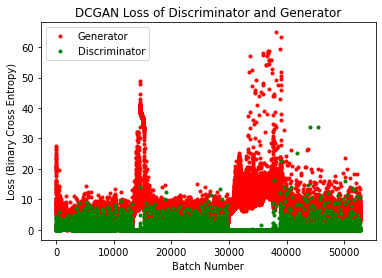

In [11]:
# Plot the loss of the generator and the descriminator
plt.plot(counterList, genLossList, 'r.', label='Generator')
plt.plot(counterList, disLossList, 'g.', label='Discriminator')
plt.title("DCGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Loss (Binary Cross Entropy)")
plt.legend(loc="best")
plt.show()